# Part 2: Wenzinger's test case

In [27]:
# import libraries and modules needed
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

# integrate plots into the notebook
%matplotlib inline

In [28]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [29]:
def define_panels(x, y, N):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels


In [30]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [31]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [32]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [33]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [34]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    
    return b

In [35]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

In [36]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b

In [37]:
def compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_m)
    strengths = numpy.append(strengths,gamma_f)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [38]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [39]:
def rotation(point, theta, x, y):
    
    theta_1 = theta/180*numpy.pi
    x_1, y_1= 0,0
    x_1, y_1 = x-point[0]*numpy.ones_like(x), y-point[1]*numpy.ones_like(y)

    x_r = x_1*numpy.cos(theta_1)+y_1*numpy.sin(theta_1)+point[0]*numpy.ones_like(x)
    y_r = x_1*(-1)*numpy.sin(theta_1)+y_1*numpy.cos(theta_1)+point[1]*numpy.ones_like(y)
    
    return x_r, y_r

In [40]:
x_m, y_m = numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_MainFoil.csv", dtype=float, delimiter=',', unpack=True)

x_f, y_f = numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv", dtype=float, delimiter=',', unpack=True)

N = len(x_m)-1

u_inf, alpha = 1.0, 0.0

panels_m = define_panels(x_m, y_m, N)

panels_f = define_panels(x_f, y_f, N)

point = [1.03,-0.054]

theta = 20

x_f, y_f = rotation(point, theta, x_f, y_f)

(-0.2, 0.2)

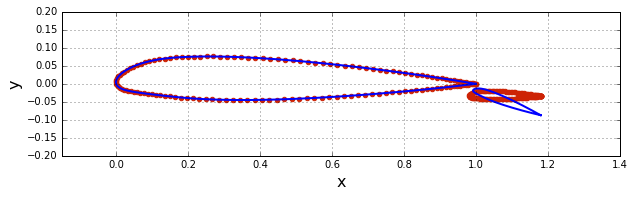

In [41]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m, y_m, x_f, y_f, color='b', linestyle='-', linewidth=2)
pyplot.scatter([panel.xa for panel in panels_m],[panel.ya for panel in panels_m],color='#CD2305')
pyplot.scatter([panel.xa for panel in panels_f],[panel.ya for panel in panels_f],color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.2, 0.2)

In [42]:
panels = numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_m[i]
    elif i>=N:
        panels[i]=panels_f[i-N]


In [43]:
A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)

In [ ]:
alpha = 0
alpha_1, alpha_2 = -14, 14
erro_1 = 1
while erro_1>0.0001:
    
    alpha = 0.5*(alpha_1+alpha_2)
    lift_1, lift_2 = 0, 0
    freestream = Freestream(u_inf, alpha_1)
    b = build_freestream_rhs(panels, freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
        gamma_m = strengths[-2]
        gamma_f = strengths[-1]
        compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
        compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        lift_2 -=panel.cp*numpy.sin(panel.beta)*panel.length
        
    freestream = Freestream(u_inf, alpha)
    b = build_freestream_rhs(panels, freestream)
    strengths = numpy.linalg.solve(A, b)
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
        gamma_m = strengths[-2]
        gamma_f = strengths[-1]
        compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
        compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        lift_1 -=panel.cp*numpy.sin(panel.beta)*panel.length
    
    if lift_1*lift_2<0:
        alpha_2=alpha
    elif lift_1*lift_2>0:
        alpha_1=alpha
    erro_1=abs(lift_1)
